In [1]:
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
import matplotlib.pyplot as plt
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from tqdm import tqdm

2024-02-07 02:07:43.282911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 02:07:43.377756: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 02:07:43.870856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-07 02:07:43.870908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_original/*.png')
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/random_walk_chest_128_slic800/*.png')
image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast_rw/train/image/*.jpg')
mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast_rw/train/mask/*.jpg')

In [3]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [4]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

def sensitivity(gt_mask, pred_mask):

    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [5]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred, smooth=1)

In [6]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (128, 128))

                mask = cv2.imread(mask_path,0)
                mask = cv2.resize(mask, (128, 128))


                # normalize the image and mask to have values between 0 and 1
                img = img / 255.0
                mask= mask/ 255.0


                batch_images.append(img)
                batch_masks.append(mask)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)


            yield batch_images, batch_masks
# #
# generator = data_generator(image_paths, mask_paths, 1)
# 
# for _,imgpath in tqdm(enumerate(image_paths)):
#    batch = next(generator)

In [7]:
assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=2023
)

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)

1443
360


In [8]:
from keras.applications import MobileNetV2

IMAGE_SIZE = 128
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(n_filters=16, batchnorm=True, dropout=0.1, num_classes=1):
    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = tf.keras.utils.get_file(model_name, weight_path)

    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output

    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides=(2, 2), padding='same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size=3, batchnorm=batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size=3, batchnorm=batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides=(2, 2), padding='same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size=3, batchnorm=batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size=3, batchnorm=batchnorm)

    # Output layer with sigmoid activation for binary segmentation
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [9]:
!rm -rf '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [10]:
%load_ext tensorboard
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [11]:
# weight_path="{}_Unet_superpixel_random_walk_chest_slic800.best.hdf5".format('cxr_reg')
weight_path="{}_Unet_superpixel_random_walk_breast_slic800.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2024-02-07 02:08:17.218360: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-02-07 02:08:17.218395: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-02-07 02:08:17.255223: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2024-02-07 02:08:17.255466: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2024-02-07 02:08:17.296488: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-02-07 02:08:17.296758: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [12]:
model =unet(n_filters = 8, batchnorm = True, dropout = 0.1, num_classes=1)
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss=dice_loss, metrics= [dice_coef, precision, sensitivity, iou],  run_eagerly=True)
model.summary()

2024-02-07 02:08:23.557047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-07 02:08:23.579582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-07 02:08:23.579767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-07 02:08:23.580194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [14]:
loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

model.save("unet_superpixel_random_walk_chest_slic800.h5")
# model.save("unet_superpixel_random_walk_breast_slic800.h5")


Number of images: 11544
Number of masks: 11544
Epoch 1/50


/tmp/ipykernel_5277/484670927.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(
2024-01-29 11:22:58.917611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-01-29 11:22:59.840300: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-29 11:22:59.841337: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-29 11:22:59.841351: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-

2024-01-29 11:23:02.301654: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-29 11:23:02.379514: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-29 11:23:02.518495: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

   1/1443 [..............................] - ETA: 6:04:17 - loss: 0.7718 - dice_coef: 0.2282 - precision: 0.1396 - sensitivity: 0.6299 - iou: 0.1288

2024-01-29 11:23:12.333422: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-29 11:23:12.444291: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-29 11:23:12.444313: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


   2/1443 [..............................] - ETA: 17:24 - loss: 0.8076 - dice_coef: 0.1924 - precision: 0.1142 - sensitivity: 0.6465 - iou: 0.1069  

2024-01-29 11:23:13.076867: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2024-01-29 11:23:13.095835: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2024-01-29 11:23:13.140847: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 1641 callback api events and 1738 activity events. 
2024-01-29 11:23:13.158038: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-29 11:23:13.159926: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2024_01_29_11_23_13/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


1443/1443 [==============================] - ETA: 0s - loss: 0.3778 - dice_coef: 0.6222 - precision: 0.6568 - sensitivity: 0.7506 - iou: 0.4707Number of images: 2886
Number of masks: 2886

Epoch 1: val_loss improved from inf to 0.37473, saving model to cxr_reg_Unet_superpixel_random_walk_breast_slic800.best.hdf5
1443/1443 [==============================] - 282s 185ms/step - loss: 0.3778 - dice_coef: 0.6222 - precision: 0.6568 - sensitivity: 0.7506 - iou: 0.4707 - val_loss: 0.3747 - val_dice_coef: 0.6253 - val_precision: 0.8770 - val_sensitivity: 0.5232 - val_iou: 0.4686 - lr: 1.0000e-04
Epoch 2/50
1443/1443 [==============================] - ETA: 0s - loss: 0.2402 - dice_coef: 0.7598 - precision: 0.8103 - sensitivity: 0.7578 - iou: 0.6249
Epoch 2: val_loss improved from 0.37473 to 0.27665, saving model to cxr_reg_Unet_superpixel_random_walk_breast_slic800.best.hdf5
1443/1443 [==============================] - 255s 177ms/step - loss: 0.2402 - dice_coef: 0.7598 - precision: 0.8103 - sens

In [13]:
test_images = []
ground_truth_test_images = []

# test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_original/*.png")
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_mask/*.png")

test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test_mask/*.png")

In [14]:
from tensorflow.keras.models import load_model

model = load_model("unet_superpixel_random_walk_breast_slic800.h5", custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef, 'precision': precision, 'sensitivity': sensitivity, 'iou': iou})

In [15]:
model.load_weights("{}_Unet_superpixel_random_walk_breast_slic800.best.hdf5".format('cxr_reg'))

In [16]:
dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

(69, 128, 128, 3)
(69, 128, 128)


/home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-02-07 02:10:02.599693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-02-07 02:10:03.003499: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-02-07 02:10:03.004440: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to t

 3/69 [>.............................] - ETA: 2s  

2024-02-07 02:10:03.362679: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-07 02:10:03.362721: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-07 02:10:03.421277: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-07 02:10:03.421324: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

69/69 [==============================] - 4s 37ms/step
(69, 128, 128, 1)
(69, 128, 128, 1)
(69, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float64, numpy=0.7521933242924468>, <tf.Tensor: shape=(), dtype=float64, numpy=0.586292593155734>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9317284197261453>, <tf.Tensor: shape=(), dtype=float64, numpy=0.35693114297631845>, <tf.Tensor: shape=(), dtype=float64, numpy=0.04207576374004768>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9117232349682748>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9161706329613902>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9322285673622601>, <tf.Tensor: shape=(), dtype=float64, numpy=0.941148544674721>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9069742239702276>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7249906331959536>, <tf.Tensor: shape=(), dtype=float64, numpy=0.887578133029366>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7979842413735105>, <tf.Tensor: shape=(), dtype=float64, numpy=0.51515708422

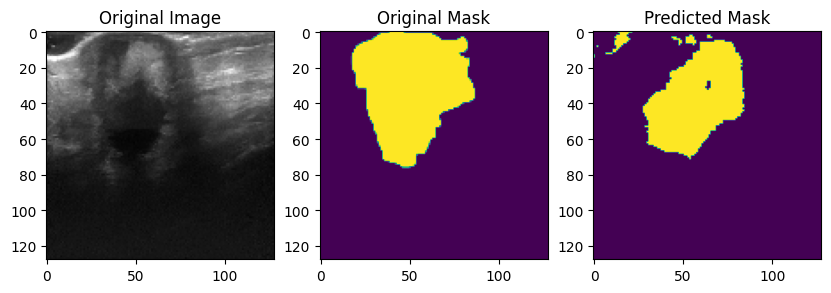

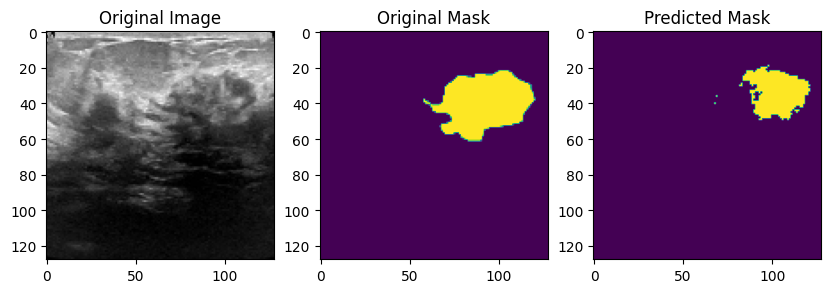

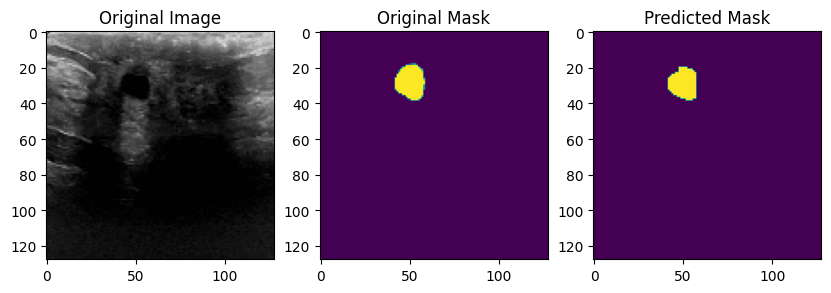

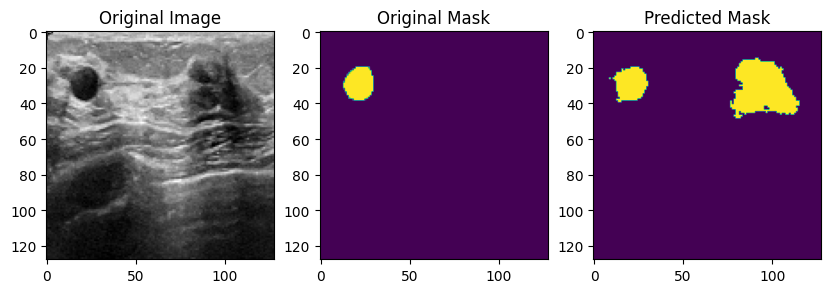

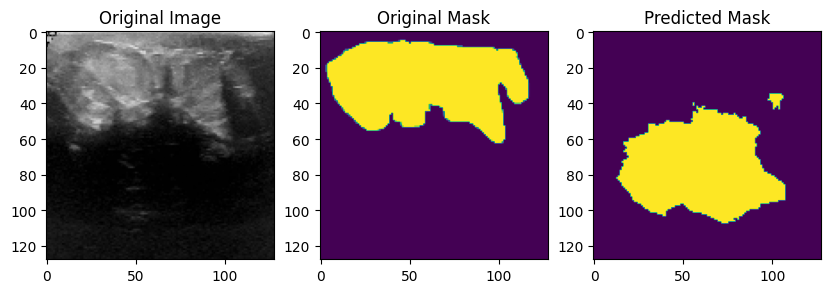

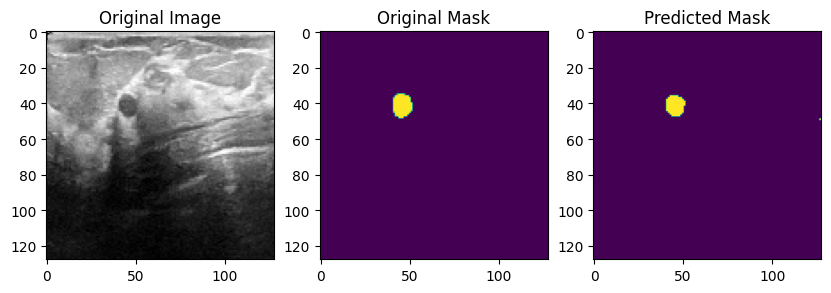

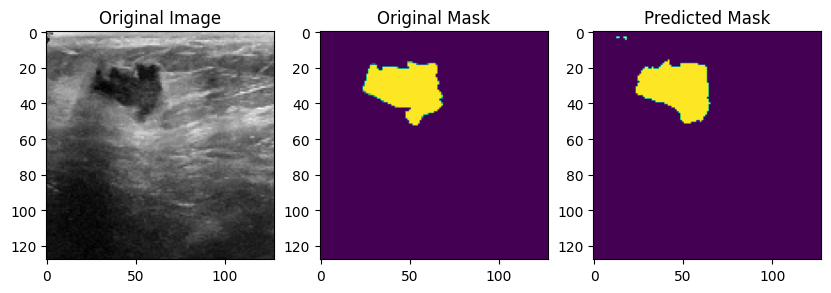

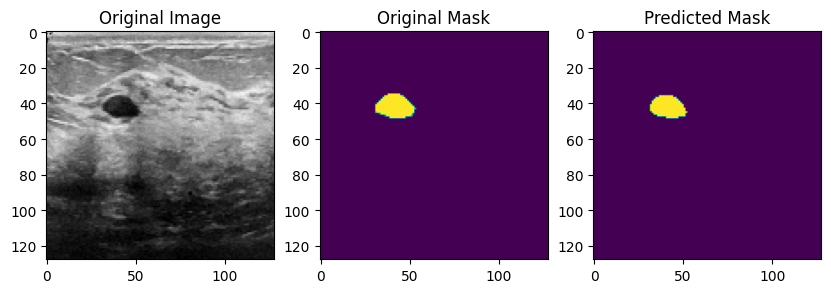

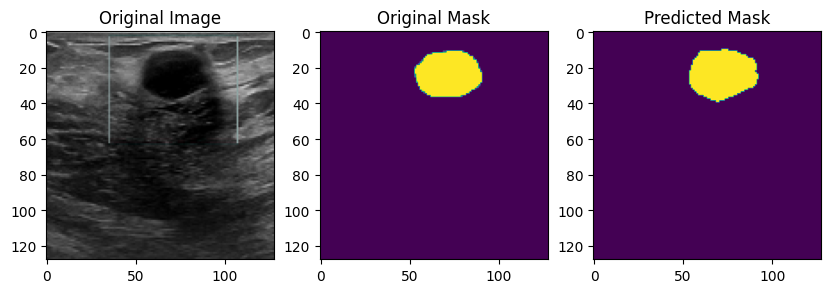

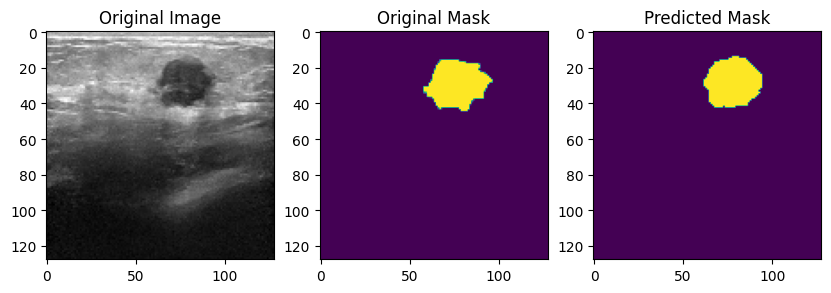

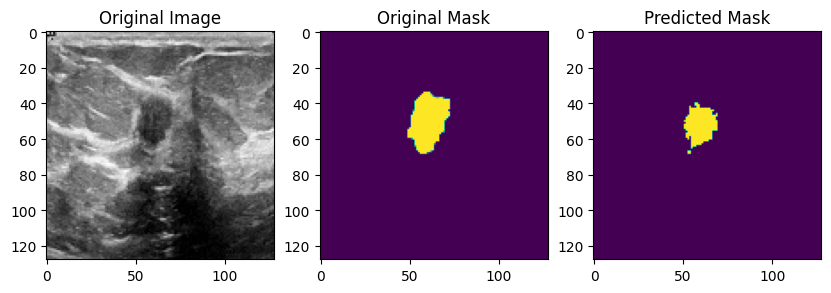

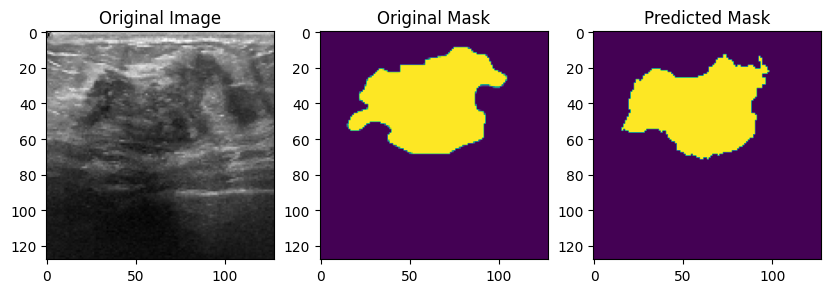

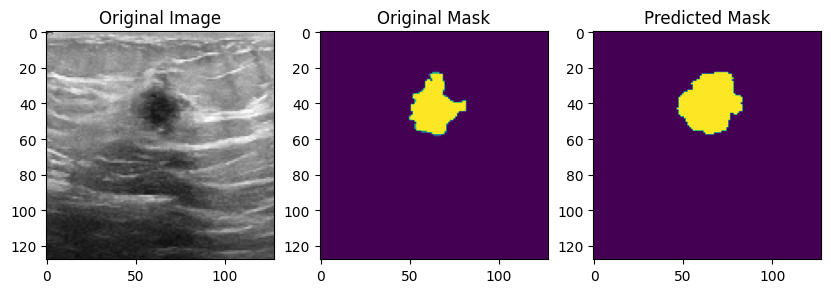

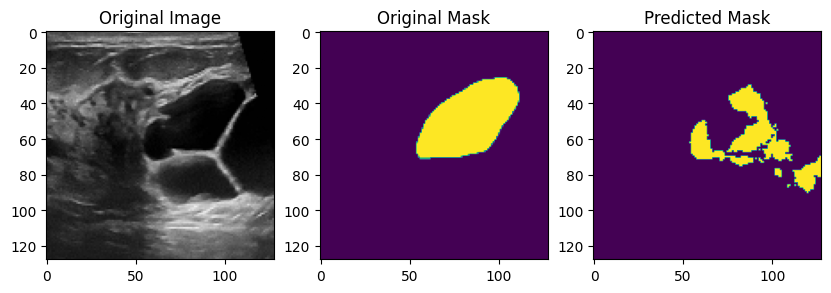

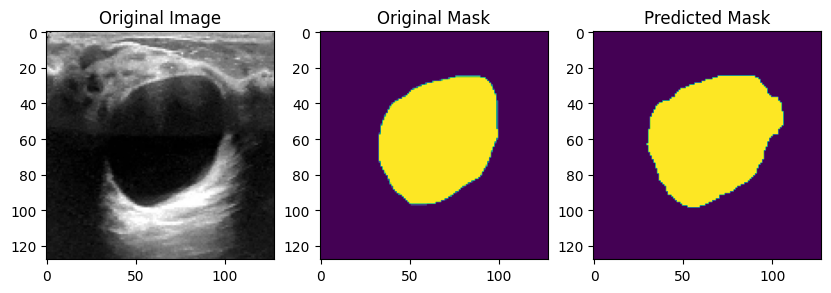

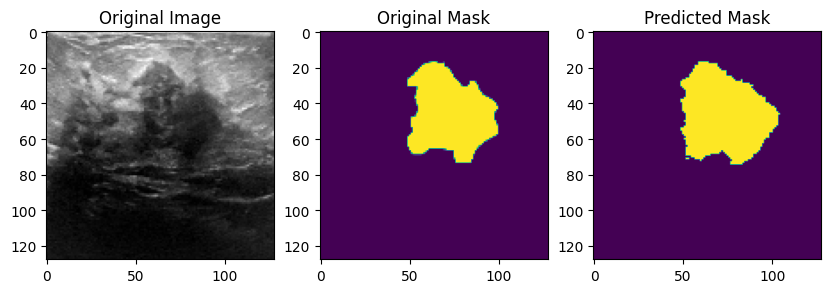

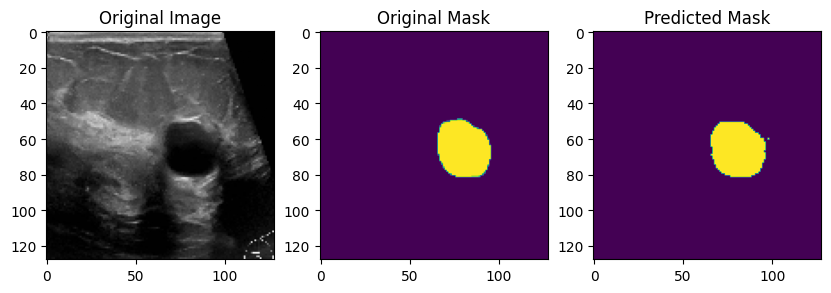

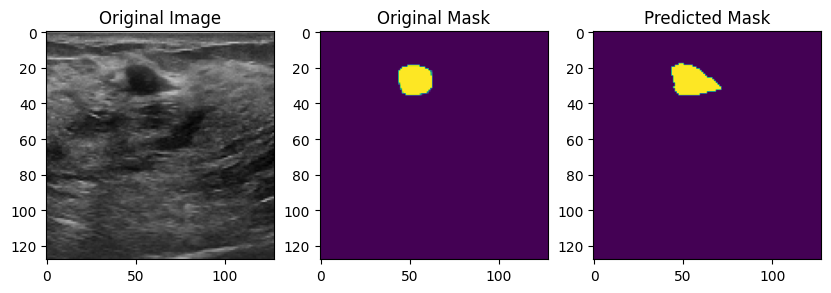

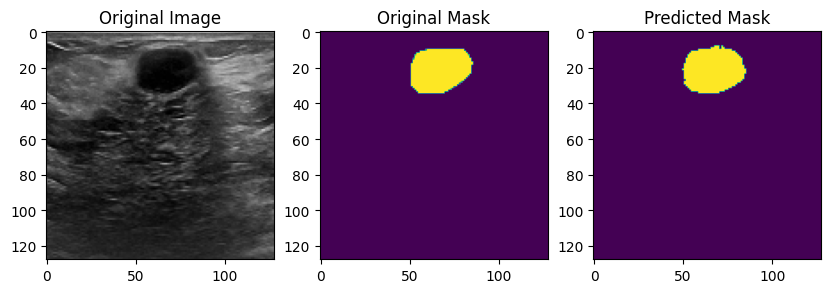

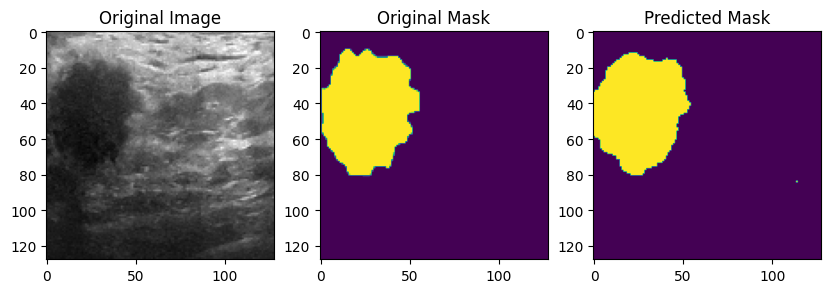

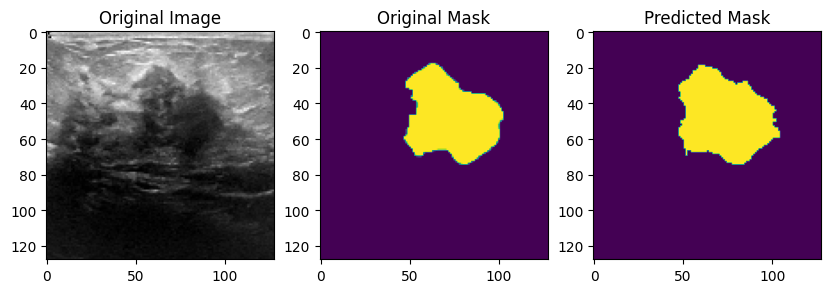

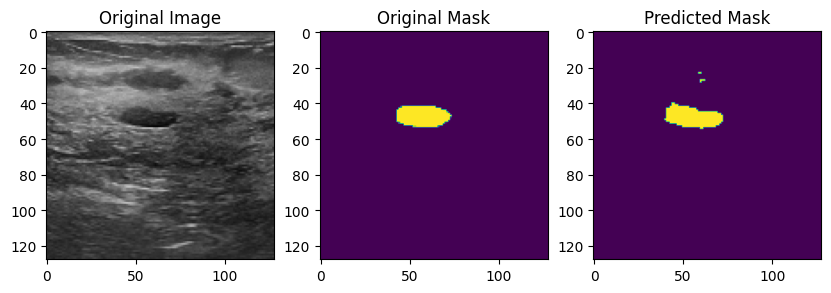

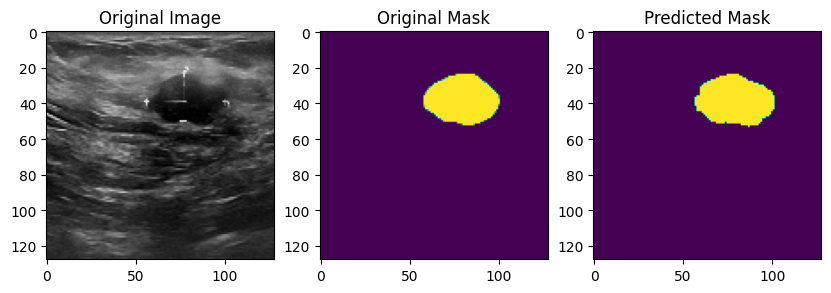

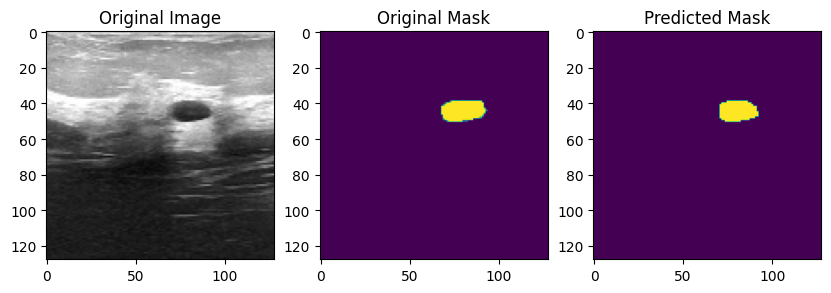

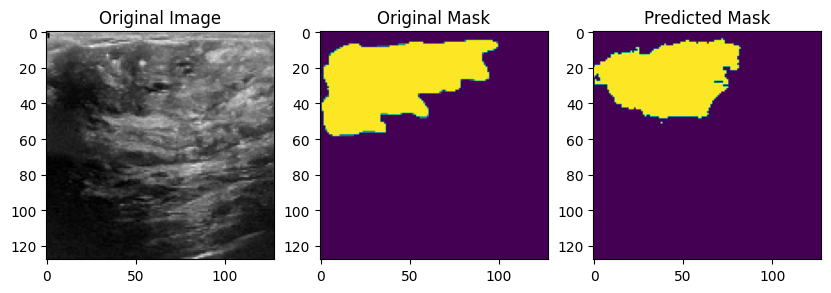

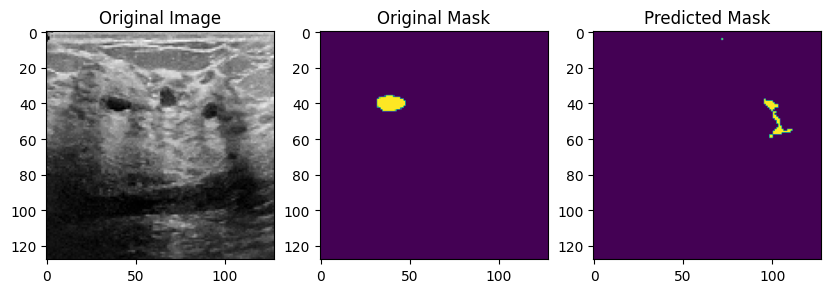

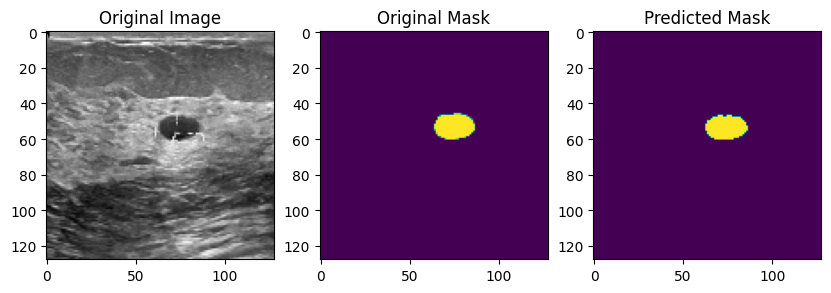

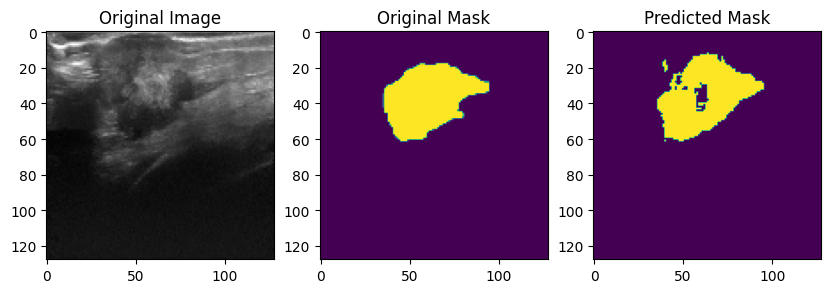

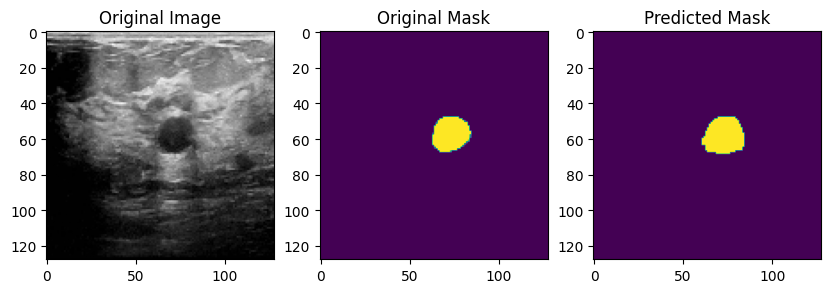

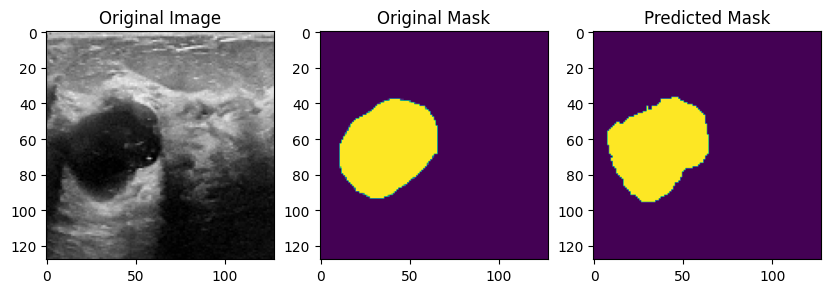

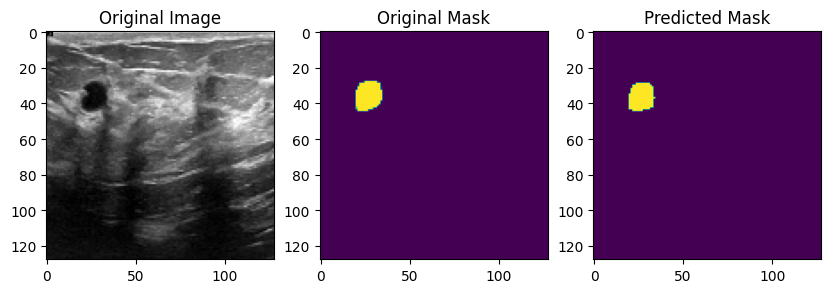

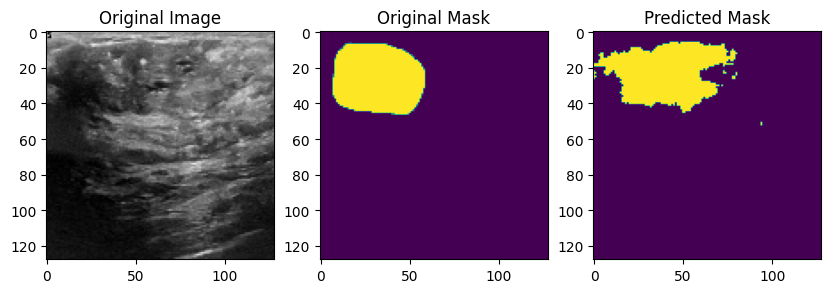

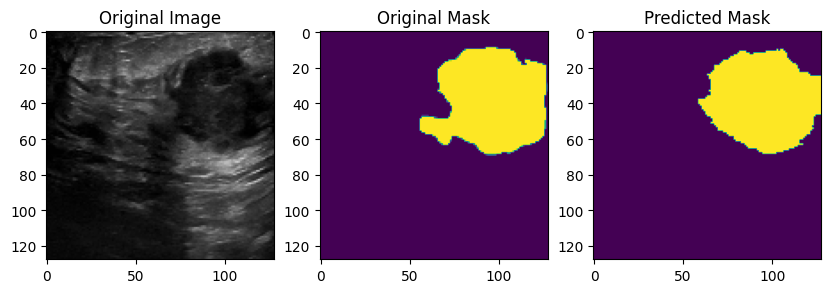

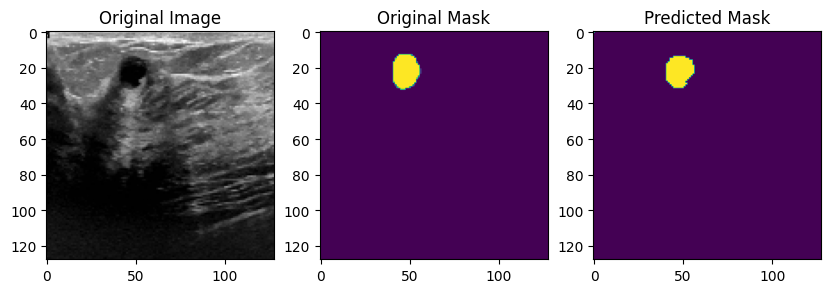

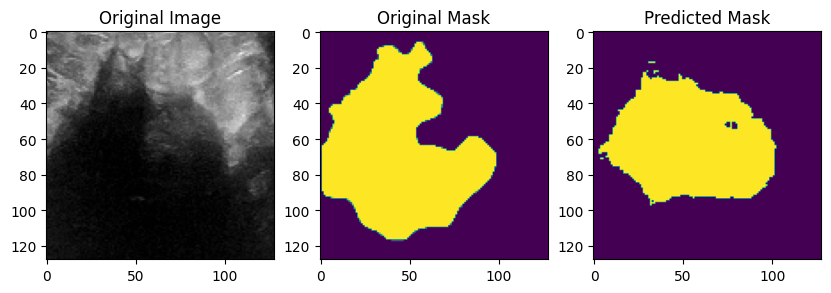

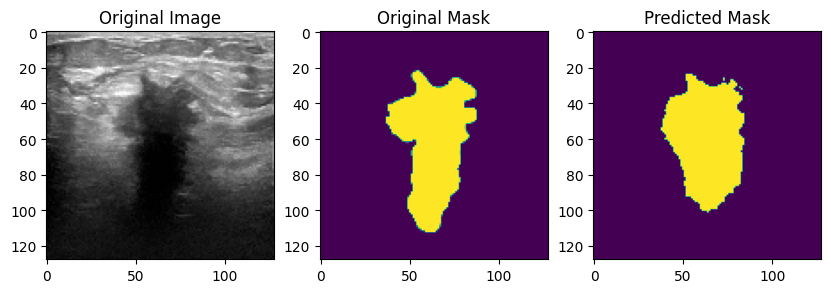

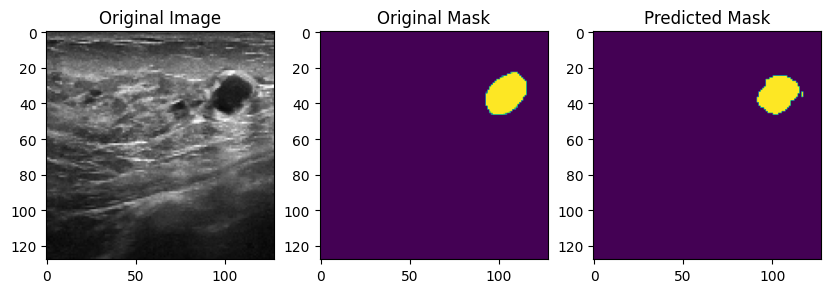

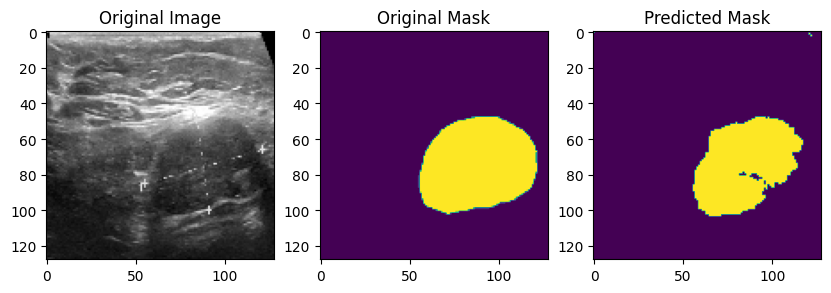

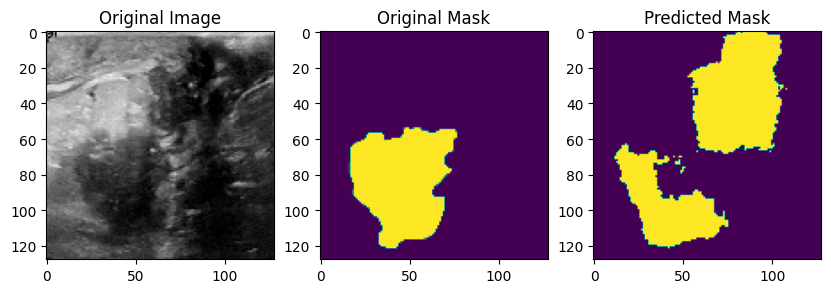

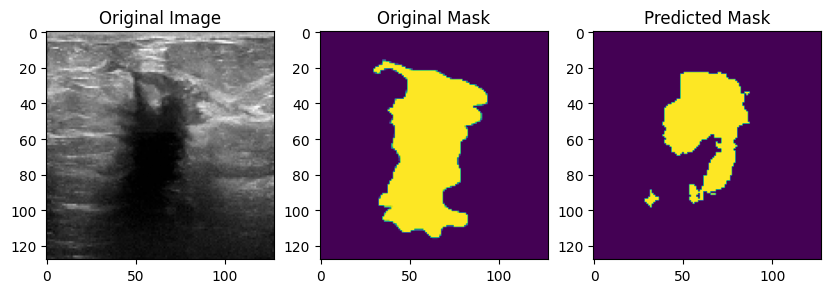

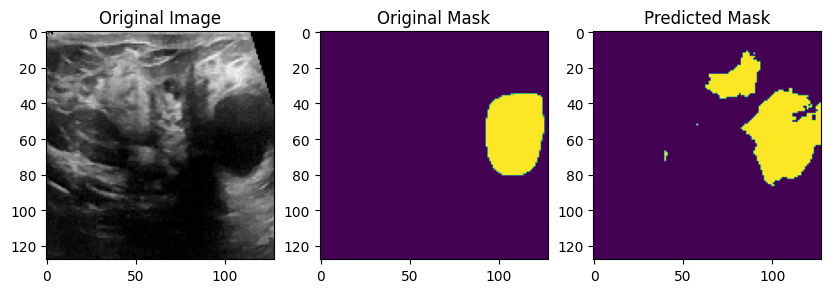

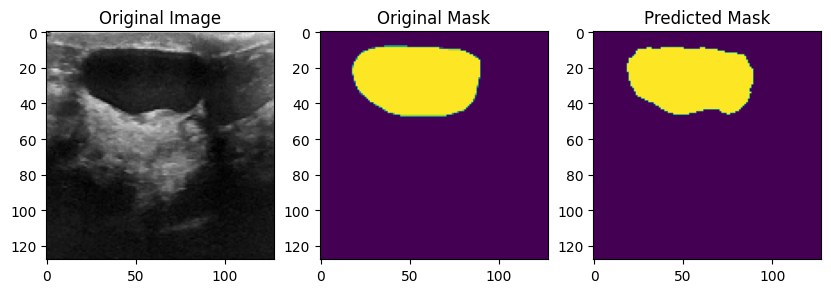

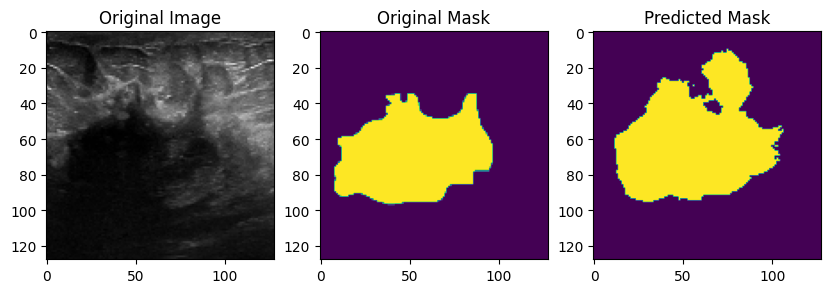

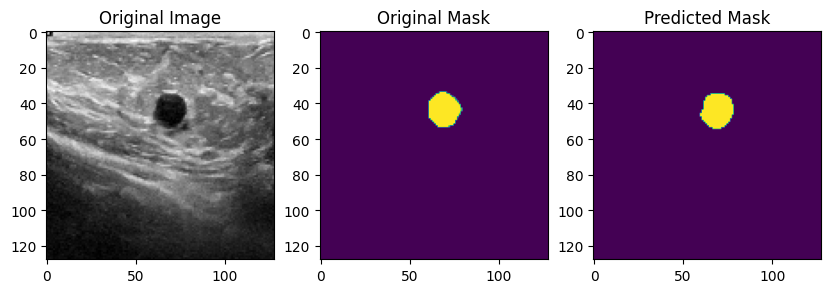

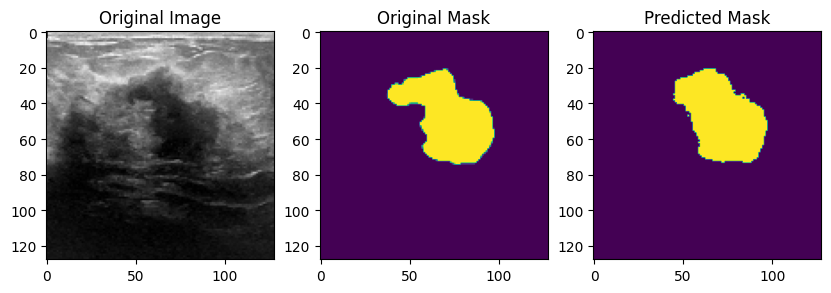

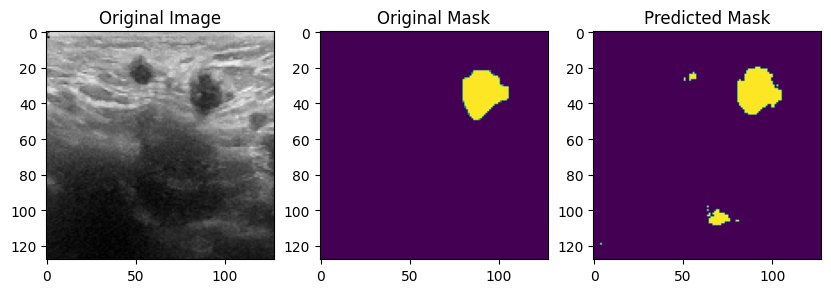

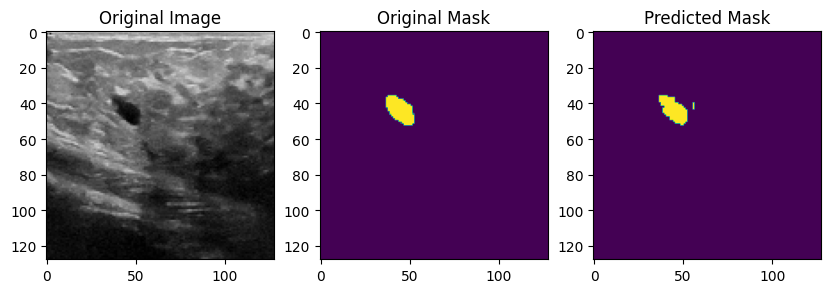

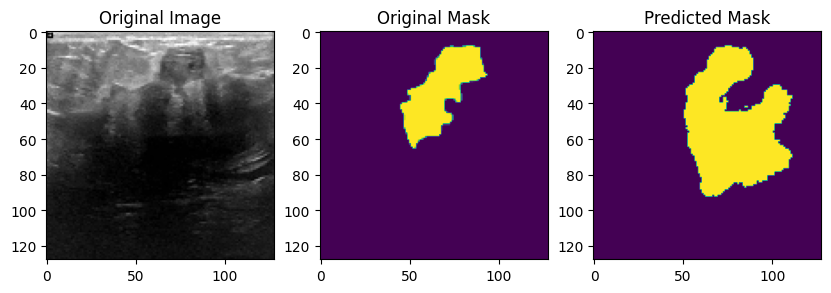

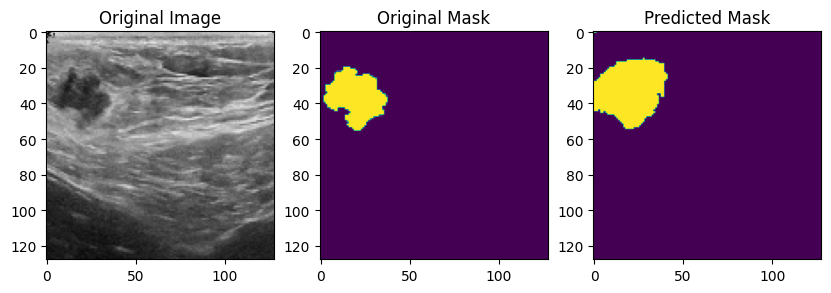

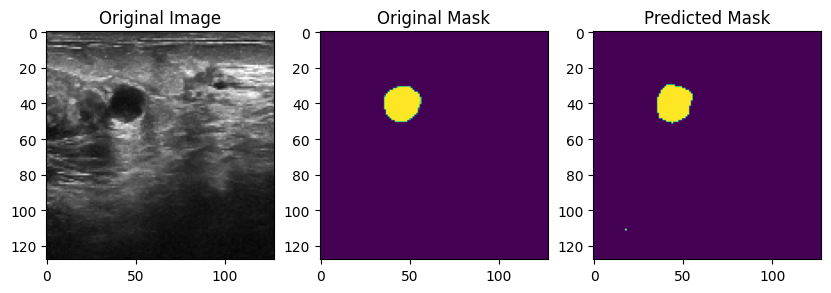

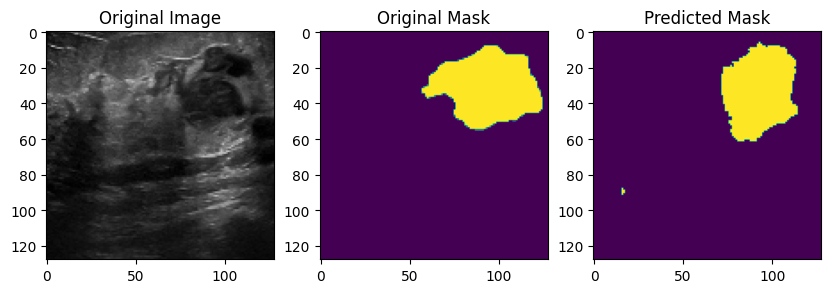

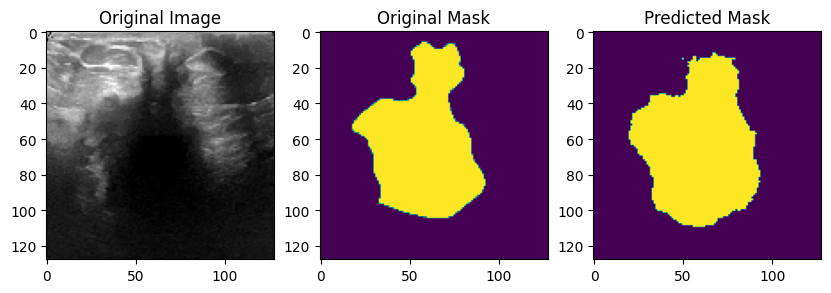

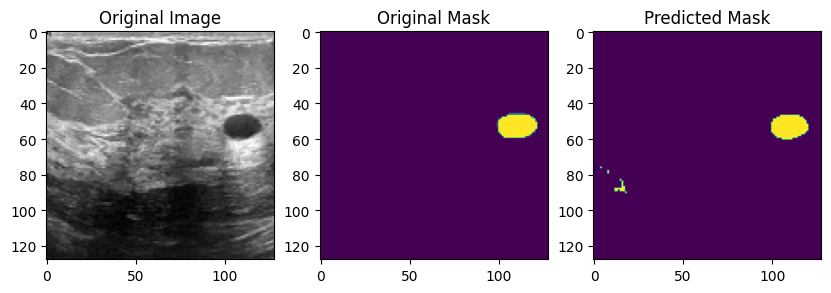

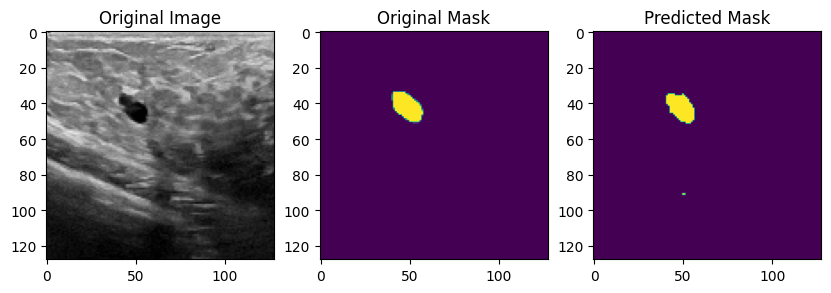

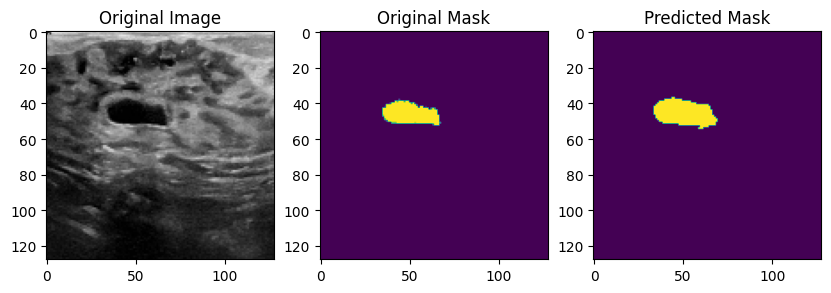

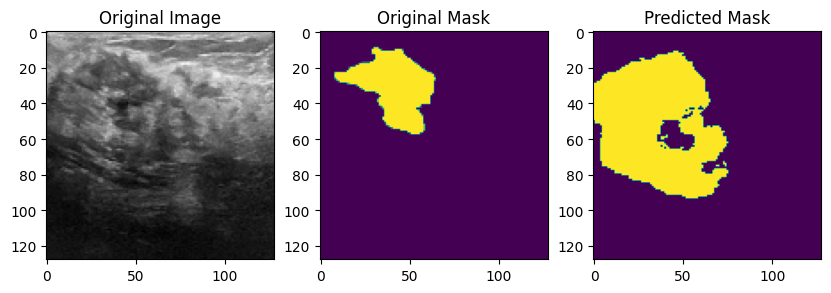

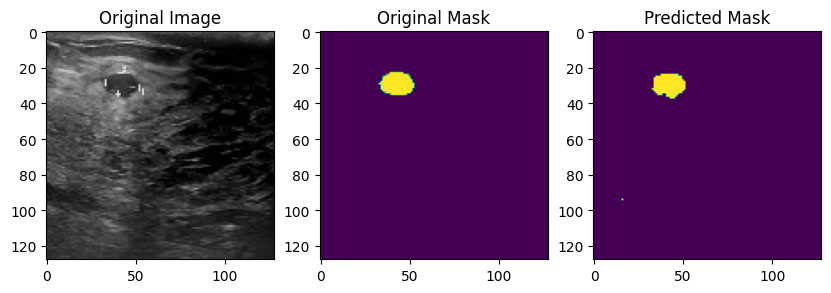

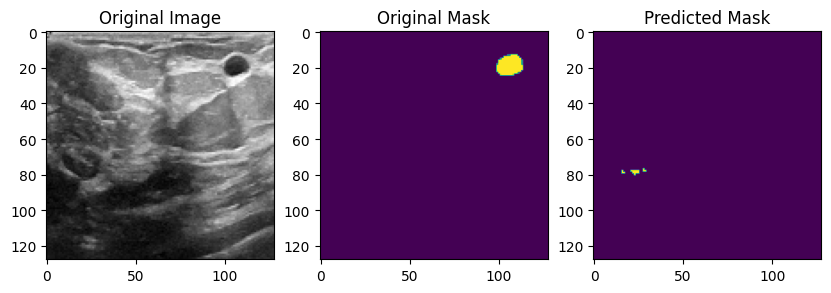

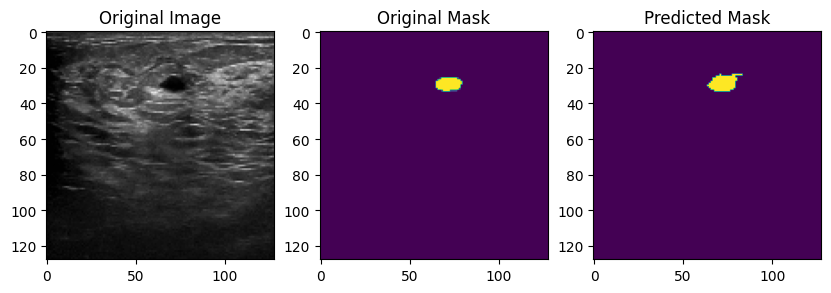

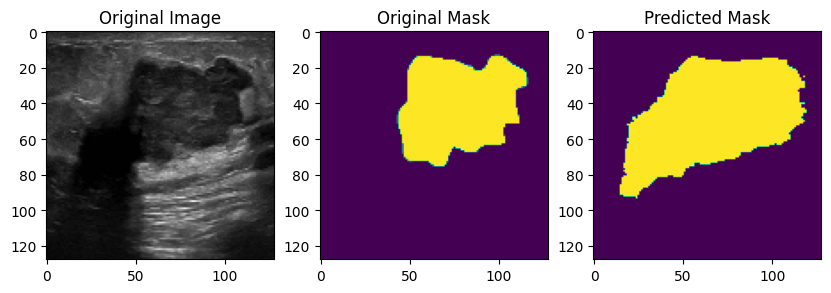

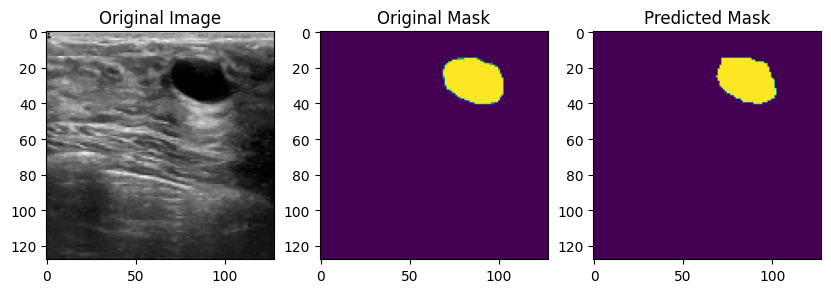

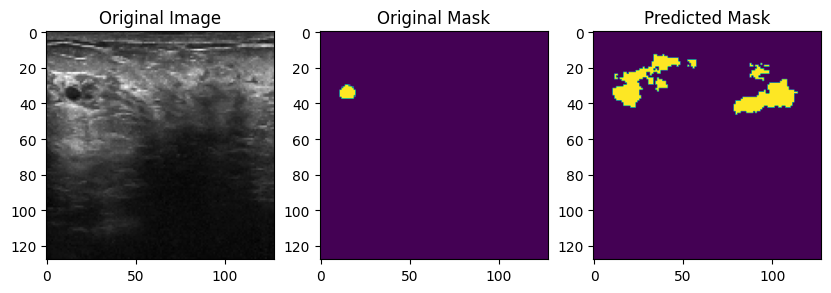

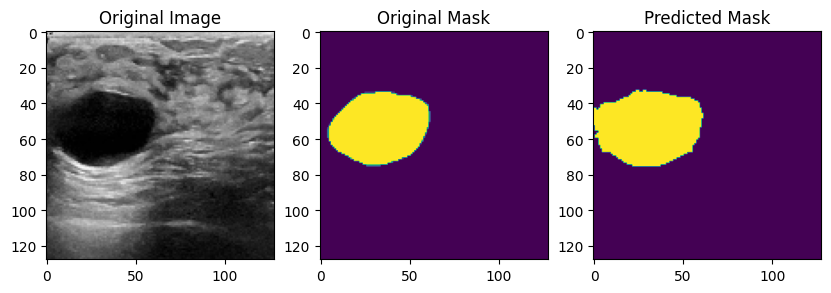

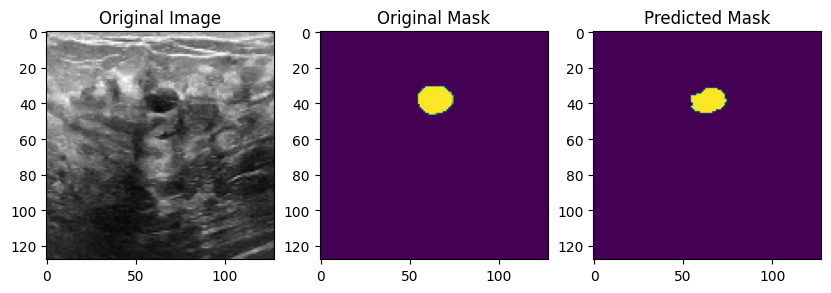

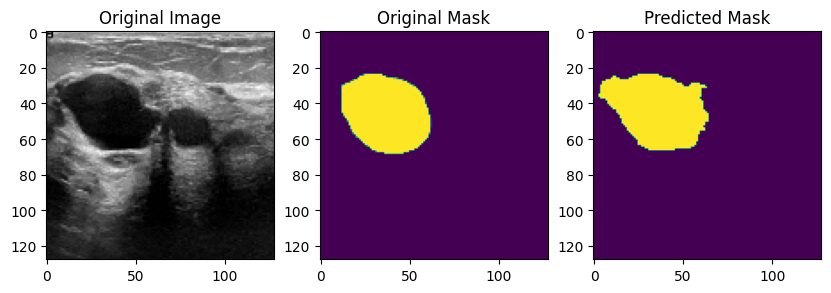

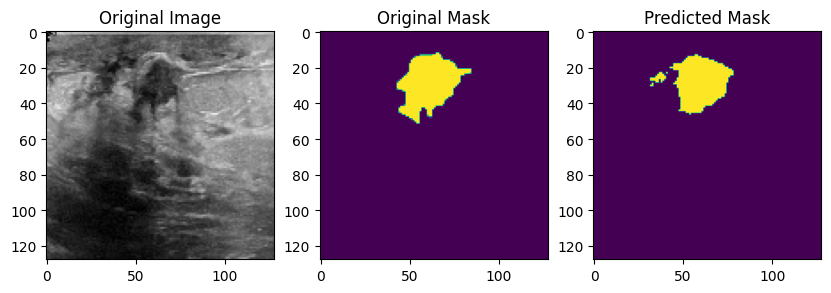

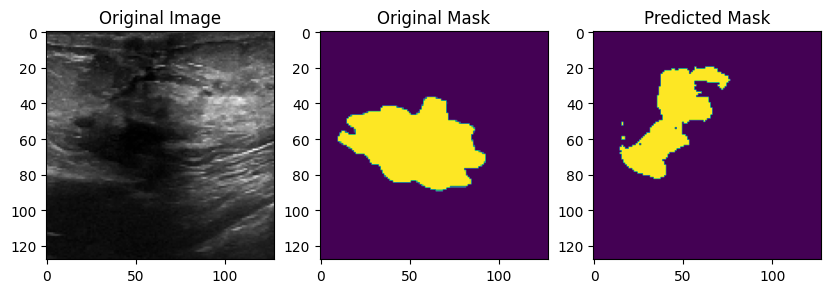

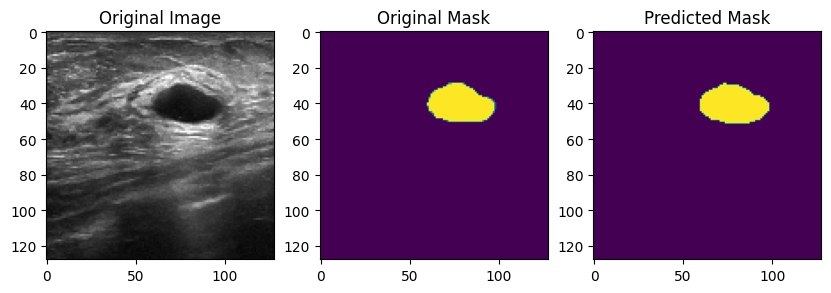

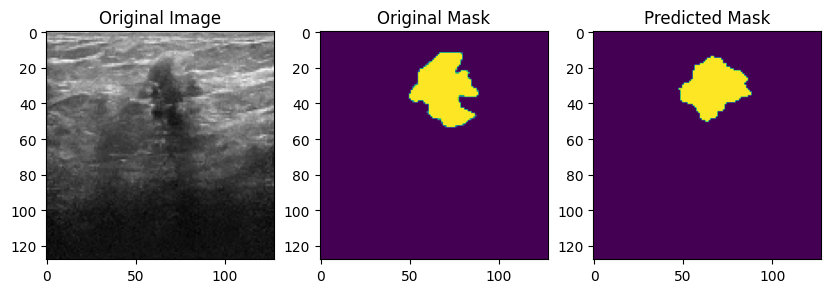

In [17]:
for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

# normalize the image and mask to have values between 0 and 1

    test_image = test_image / 255.0
    ground_truth_test_image= ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)


#by the end of this line, I have superpixeled images.
# convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)
print(test_images.shape)
print(ground_truth_test_images.shape)
# add a channel dimension to the masks
# ground_truth_test_images = np.expand_dims(ground_truth_test_images, axis=-1)


# Make predictions
# predicted_masks = model.predict(test_images)
tf.config.run_functions_eagerly(True)
predicted_masks = model.predict(
    test_images,
    batch_size=1,
    verbose=1,
    steps=None,
    callbacks=None
)

predicted_mask_array = np.array(predicted_masks)
print(predicted_mask_array.shape)

# Convert the NumPy array to uint8 format
predicted_mask_array = (predicted_mask_array * 255).astype(np.uint8)
print(predicted_mask_array.shape)

#
dst = np.empty([predicted_mask_array.shape[0],predicted_mask_array.shape[1],predicted_mask_array.shape[2]])
kernel = np.ones((5,5),np.float64)/25
# dst = predicted_mask_array

#
for i in range(predicted_mask_array.shape[0]):

        threshold_value = 1
        _, dst[i] = cv2.threshold(predicted_mask_array[i], threshold_value, 255, cv2.THRESH_BINARY)
        dst[i] = np.array(dst[i])
        dst[i] = tf.convert_to_tensor(dst[i] / 255.0,dtype=predicted_masks.dtype)

print(dst.shape)

## Cast the input tensor to a double tensor
ground_truth_test_images = tf.cast(ground_truth_test_images, dtype=tf.float64)
predicted_masks = tf.cast(dst, dtype=tf.float64)
# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    precision_value = precision(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)

n =69 # number of images to show
for i in range(n):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i])
    ax[1].set_title('Original Mask')
    ax[2].imshow(dst[i])
    ax[2].set_title('Predicted Mask')
    plt.show()



In [22]:
import os
# Define the base directory where you want to save the images
base_save_path = "/home/somayeh/PycharmProjects/superpixel_segmentation/result_images/unet_rw_breast_slic800"

# Subdirectories for each image type
original_images_dir = os.path.join(base_save_path, "original_images")
original_masks_dir = os.path.join(base_save_path, "original_masks")
predicted_masks_dir = os.path.join(base_save_path, "predicted_masks")

# Create the directories if they do not exist
os.makedirs(original_images_dir, exist_ok=True)
os.makedirs(original_masks_dir, exist_ok=True)
os.makedirs(predicted_masks_dir, exist_ok=True)

In [23]:
n = 200  # Number of images to show
import numpy as np
for i in range(n):
    # Convert TensorFlow tensors to numpy arrays and ensure they are scaled to 0-255 range and in uint8 format
    original_image = np.array(test_images[i] * 255, dtype=np.uint8)
    ground_truth_mask = np.array(ground_truth_test_images[i] * 255, dtype=np.uint8)
    predicted_mask = np.array(dst[i] * 255, dtype=np.uint8)

    # Ensure masks are in 3-channel format if original image is in color
    if len(ground_truth_mask.shape) == 2:
        ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_GRAY2BGR)
    if len(predicted_mask.shape) == 2:
        predicted_mask = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2BGR)

    # # Display original image
    # cv2.imshow('Original Image', original_image)
    # cv2.waitKey(0)  # Wait for key press to continue

    # # Display original mask
    # cv2.imshow('Original Mask', ground_truth_mask)
    # cv2.waitKey(0)  # Wait for key press to continue

    # Display predicted mask
    # cv2.imshow('Predicted Mask', predicted_mask)
    # cv2.waitKey(0)  # Wait for key press to continue

    # # Optionally, save images if needed
    # cv2.imwrite(f"original_image_{i}.png", original_image)
    # cv2.imwrite(f"ground_truth_mask_{i}.png", ground_truth_mask)
    # cv2.imwrite(f"predicted_mask_{i}.png", predicted_mask)
    
    # Save the images with their respective paths
    cv2.imwrite(os.path.join(original_images_dir, f"original_image_{i}.png"), original_image)
    cv2.imwrite(os.path.join(original_masks_dir, f"ground_truth_mask_{i}.png"), ground_truth_mask)
    cv2.imwrite(os.path.join(predicted_masks_dir, f"predicted_mask_{i}.png"), predicted_mask)

# cv2.destroyAllWindows()  # Close all OpenCV windows after displaying all images

IndexError: index 69 is out of bounds for axis 0 with size 69